<a href="https://colab.research.google.com/github/chinmay250/Malaria-Detection/blob/main/malaria_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **WandB install, Login, Initialization and Configuration**

In [5]:
pass

## **Import Libraries**

In [9]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import InputLayer

## **Loading Dataset**

In [15]:
## Load the malaria images dataset from tensorflow

dataset, dataset_info = tfds.load("malaria",
                                  with_info=True,
                                  as_supervised=True,
                                  shuffle_files=True,
                                  split =["train"])

In [41]:
## checking the dataset and dataset_info

print(dataset)
print(dataset_info)

[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]
tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='/root/tensorflow_datasets/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
  

In [21]:
## Function for splitting the dataset into train,validation,test

def splits(dataset,train_ratio: float,val_ratio:float,test_ratio:float):
    DATASET_SIZE = len(dataset)
    train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))
    val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
    val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))
    test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))

    return train_dataset,val_dataset,test_dataset


In [22]:
## Applying the splits function
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

train,val,test = splits(dataset[0],TRAIN_RATIO,VAL_RATIO,TEST_RATIO)


In [24]:
## Printing the first data points

print(list(train.take(1).as_numpy_iterator()))
print(list(val.take(1).as_numpy_iterator()))
print(list(test.take(1).as_numpy_iterator()))


[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 1)]
[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
     

## **Data Visualization**

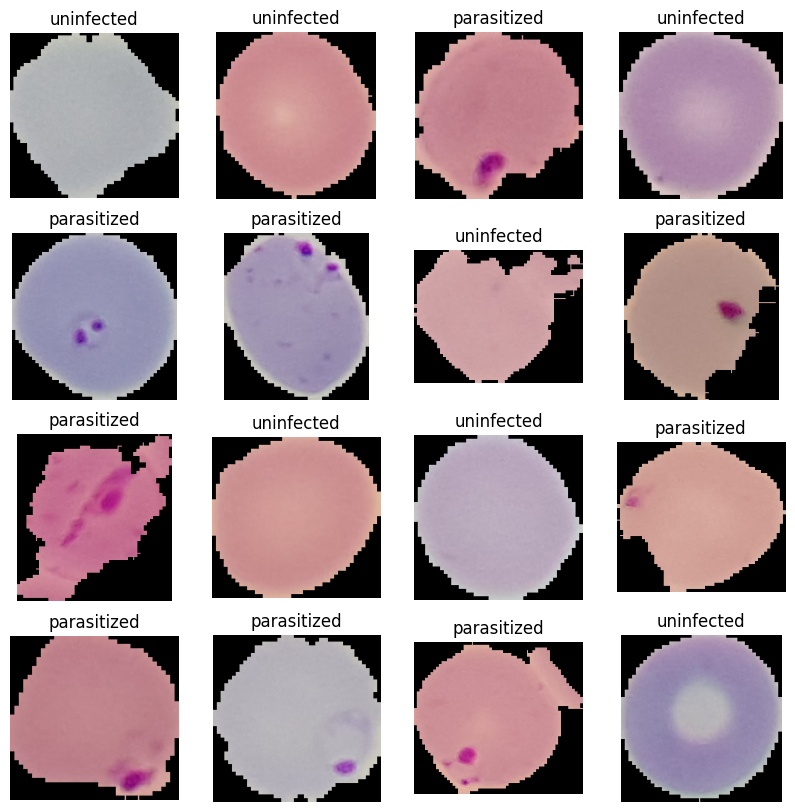

In [43]:
plt.figure(figsize=[10,10])
for i,(image,label) in enumerate(train.take(16)):
    ax = plt.subplot(4,4,i+1)
    plt.imshow(image)
    plt.title(dataset_info.features["label"].int2str(label))
    plt.axis("off")

## **Data Preprocessing**

In [54]:
## Resizing the image to 224 x 224 and rescaling

IM_SIZE = 224
def resize_rescale(image,label):
    return tf.image.resize(image,(IM_SIZE,IM_SIZE))/255.0,label


In [55]:
train = train.map(resize_rescale)

In [56]:
for image,label in train.take(1):
    print(image,label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(1, shape=(), dtype=int64)


In [57]:
BATCH_SIZE = 32
train_dataset = train.shuffle(buffer_size=8,reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)